In [186]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
import utils.plot
import models.train_metaClf

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

resolution='5'
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res'+resolution
with open(os.path.join(savedir_baseline,'pca_dapi_600'), 'rb') as output:
    pca_dapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_gfap_600'), 'rb') as output:
    pca_gfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_map2_600'), 'rb') as output:
    pca_map2=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_lmnb_600'), 'rb') as output:
    pca_lmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'modAll'), 'rb') as output:
    modAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'silAll'), 'rb') as output:
    silAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'moddapi'), 'rb') as output:
    moddapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'sildapi'), 'rb') as output:
    sildapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'modgfap'), 'rb') as output:
    modgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'silgfap'), 'rb') as output:
    silgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'modmap2'), 'rb') as output:
    modmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'silmap2'), 'rb') as output:
    silmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'modlmnb'), 'rb') as output:
    modlmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'sillmnb'), 'rb') as output:
    sillmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'leidenRes3_10samples'), 'rb') as output:
    leidenResAll=pickle.load(output)
    
savedir_processed='/data/xzhang/neuro/processed'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
if not os.path.exists(saveDir):
    os.mkdir(saveDir)


with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
jointPartition=np.copy(finalPartition)
modFrac=0.3
modFrac_dapi=(moddapi/modAll>modFrac).astype(int)
modFrac_map2=(modmap2/modAll>modFrac).astype(int)
modFrac_gfap=(modgfap/modAll>modFrac).astype(int)
modFrac_lmnb=(modlmnb/modAll>modFrac).astype(int)
modFrac_sum=modFrac_dapi+modFrac_gfap+modFrac_lmnb+modFrac_map2

silAll_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_mean[c]=np.mean(silAll[jointPartition==c])
    
sildapi_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_mean[c]=np.mean(sildapi[jointPartition==c])
    
silgfap_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_mean[c]=np.mean(silgfap[jointPartition==c])

silmap2_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_mean[c]=np.mean(silmap2[jointPartition==c])
sillmnb_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_mean[c]=np.mean(sillmnb[jointPartition==c])
silAll_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_pos[c]=np.sum(silAll[jointPartition==c]>0)/np.sum(jointPartition==c)
sildapi_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_pos[c]=np.sum(sildapi[jointPartition==c]>0)/np.sum(jointPartition==c)
silmap2_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_pos[c]=np.sum(silmap2[jointPartition==c]>0)/np.sum(jointPartition==c)
silgfap_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_pos[c]=np.sum(silgfap[jointPartition==c]>0)/np.sum(jointPartition==c)
sillmnb_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_pos[c]=np.sum(sillmnb[jointPartition==c]>0)/np.sum(jointPartition==c)

silmean_frac=0.3
silmean_frac_neg=2
def comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg):
    silmean_frac_dapi=np.zeros(silAll_mean.size)
    sildapi_mean_posIdx=np.arange(silAll_mean.size)[sildapi_mean>0]
    sildapi_mean_negIdx=np.arange(silAll_mean.size)[sildapi_mean<0]
#     print(sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)])
    silmean_frac_dapi[sildapi_mean_posIdx[sildapi_mean[sildapi_mean>0]>(silAll_mean[sildapi_mean>0]*silmean_frac)]]=1
    silmean_frac_dapi[sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)]]=1

    return silmean_frac_dapi

silmean_frac_dapi=comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_gfap=comparesilmean(silgfap_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_map2=comparesilmean(silmap2_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_lmnb=comparesilmean(sillmnb_mean,silAll_mean,silmean_frac,silmean_frac_neg)

silmean_frac_sum=silmean_frac_dapi+silmean_frac_gfap+silmean_frac_map2+silmean_frac_lmnb

silpos_frac=0.3
silpos_dapi=(sildapi_pos/silAll_pos>silpos_frac).astype(int)
silpos_gfap=(silgfap_pos/silAll_pos>silpos_frac).astype(int)
silpos_map2=(silmap2_pos/silAll_pos>silpos_frac).astype(int)
silpos_lmnb=(sillmnb_pos/silAll_pos>silpos_frac).astype(int)

silPos_sum=silpos_dapi+silpos_gfap+silpos_map2+silpos_lmnb


clusterIdx_pass=np.arange(np.unique(finalPartition).size)[(modFrac_sum>1)+(silmean_frac_sum>1)+(silPos_sum>1)]

nsamples=10
leidenJoint_overlap=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(leidenResAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

for s in range(nsamples):
    randomS=np.copy(jointPartition)
    np.random.seed(s)
    np.random.shuffle(randomS)

    randomAll[:,s]=randomS
leidenJoint_overlap_random=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(randomAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap_random[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

clusterIdx_robust=np.arange(np.unique(finalPartition).size)[(overlap_mean-overlap_std)>(overlap_mean_random+overlap_std_random)]
finalPartition_keep=np.intersect1d(clusterIdx_robust,clusterIdx_pass)


    
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

# annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag','Brain Weight', 'Mutations',
#                    'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed=np.array(['Path Diag','Clinical Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43',
                   'AAO', 'AAD', 'Duration', 'Gender'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight','Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])

    
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1



In [3]:
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)
meta=meta.loc[np.unique(allPatientIDs)]

In [4]:
np.unique(finalPartition_keep).size

68

In [5]:
with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
print(np.unique(allImgNames).size)
print(np.unique(allPatientIDs).size)

64
50


In [ ]:
seeds=[4,8,9,10,11,12]
for anno in annoUsed:
    print(anno)
    regrs=False
    if anno in annoUsed_numeric:
        regrs=True
    if anno not in annoUsed_numeric:
        continue
        
    
    #construct labels
    
    meta['keep']=True
    if anno not in annoUsed_numeric:
        pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
        pathDiag_unique_keep[pathDiag_counts_keep<=1]='remove'
        pathDiag_unique_keep=pathDiag_unique_keep[pathDiag_inverse_keep]

        meta['keep']=pathDiag_unique_keep!='remove'
    
    meta_allcells=meta.loc[allPatientIDs][anno].to_numpy().astype(str)
    cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
    cellIdx=np.logical_and(cellIdx,meta.loc[allPatientIDs]['keep'].to_numpy())
    allCat=meta_allcells[cellIdx]
    
    allImgNames_a=allImgNames[cellIdx]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)
    
    #get cluster composition
    clusterUnique=np.unique(finalPartition_keep_input)
    inputCluster=np.zeros((sUnique.size,clusterUnique.size))
    for i in range(sUnique.size):
        clusterRes_i=finalPartition_keep_input[allImgNames==sUnique[i]]
        for j in range(clusterUnique.size):
            inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    inputAll=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)


    if anno not in annoUsed_numeric:
        pathDiag_unique,labels,pathDiag_counts=np.unique(allCat[sidx_start],return_counts=True,return_inverse=True)
        weights=np.sum(pathDiag_counts)/pathDiag_counts
    else:
        pathDiag_unique=None
        weights=None
        labels=allCat[sidx_start].astype(float)
    if labels.size<2:
        continue
    annoName=anno
    if ' ' in anno:
        annoName=anno.split(' ')
        annoName=annoName[0]+'_'+annoName[1]
    for seed in seeds:
        print('seed: ',seed)
        name='exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed'+str(seed)+'_'+annoName
        savepath_curr=os.path.join(saveDir,'metadataClf',name)
        if not os.path.exists(os.path.join(saveDir,'metadataClf')):
            os.mkdir(os.path.join(resDir,'metadataClf'))
        if not os.path.exists(savepath_curr):
            os.mkdir(savepath_curr)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')

#         if os.path.exists(os.path.join(plotsavepath,'predictions'+str(5900)+'.csv')):
#             continue

        if not os.path.exists(logsavepath):
            os.mkdir(logsavepath)
        if not os.path.exists(modelsavepath):
            os.mkdir(modelsavepath)
        if not os.path.exists(plotsavepath):
            os.mkdir(plotsavepath)

        pIDList=allPatientIDs[sidx_start]
        models.train_metaClf.train_metaClf(inputAll, pathDiag_unique, labels, logsavepath, modelsavepath, plotsavepath, pIDList, allImgNames, sidx_start,weights=weights, use_cuda=True, seed=seed, testepoch=3500, epochs=4000, saveFreq=250, lr=0.001, weight_decay=0, batchsize=32, model_str='fc3', fc_dim=256,regrs=regrs)

In [79]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=np.array(['Control','AD','FTLD-TDPC','PSP','IPD'])):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    res_count=np.copy(res)
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(3/6*(res.shape[0]+1), 3/5*(res.shape[0])))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    print(res)
    fig.colorbar(im)
    
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            text = f"{res_count[i, j]:.0f}"  # Convert to integer format
            ax.text(j, i, text, ha="center", va="center", color="red", fontsize=8)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.set_aspect('equal')
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'),dpi=600)
    plt.show()

Path Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['AD' 'Control' 'FTLD-TDPC' 'IPD' 'PSP']
[[0.72727273 0.04545455 0.13636364 0.09090909 0.        ]
 [0.1        0.7        0.1        0.         0.1       ]
 [0.1        0.         0.4        0.3        0.2       ]
 [0.2        0.         0.3        0.4        0.1       ]
 [0.08333333 0.25       0.08333333 0.         0.58333333]]


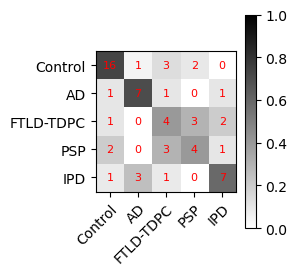

Clinical Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['AD' 'CBD' 'Control' 'FTD-SD' 'FTLD' 'IPD' 'PSP']
[[0.         0.         0.33333333 0.         0.         0.33333333
  0.         0.33333333 0.        ]
 [0.         0.         0.33333333 0.         0.33333333 0.
  0.         0.         0.33333333]
 [0.04545455 0.09090909 0.77272727 0.         0.09090909 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.         0.5        0.        ]
 [0.         0.14285714 0.42857143 0.         0.28571429 0.14285714
  0.         0.         0.        ]
 [0.5        0.         0.         0.         0.5        0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.         0.         0.5       ]
 [0.         0.         0.1        0.         0.         0.
  0.         0.8        0.1       ]
 [0.33333333 0.         0.16666667 0.         0.16666667 0.
  0.         0.         0.333333

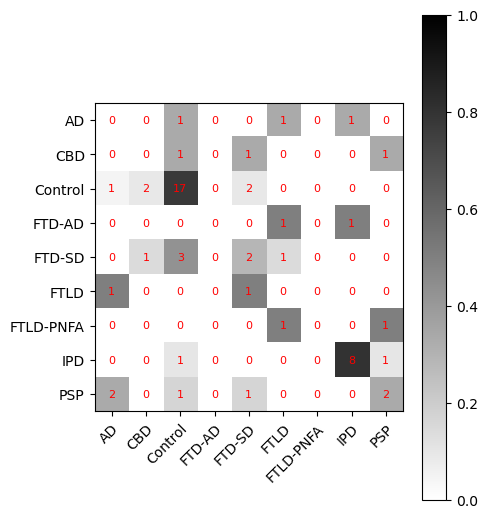

Brain Weight
Mutations
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
APOE
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['33' '34']
[[0.72222222 0.27777778]
 [0.16666667 0.83333333]]


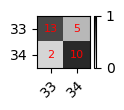

Braak Tau
Thal Phase
CERAD
CAA
SVD
alpha-syn
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['0.0' '1.0']
[[0.77272727 0.22727273]
 [0.4375     0.5625    ]]


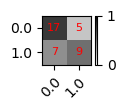

TDP43
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['0.0' '1.0']
[[0.80769231 0.19230769]
 [0.71428571 0.28571429]]


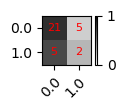

AAO
AAD
Duration
Gender
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
['F' 'M']
[[0.44117647 0.55882353]
 [0.53333333 0.46666667]]


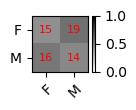

In [80]:
seeds=[4,8,9,10,11,12]
testepoch=3500

for aIdx in range(annoUsed.size):
    print(annoUsed[aIdx])
    if annoUsed[aIdx] in annoUsed_numeric:
        continue
    res_curr=np.zeros(len(seeds))
    
    pred=None
    true=None
    for seedIdx in range(len(seeds)):
        seed=seeds[seedIdx]
        print('seed: ',seed)
        annoName=annoUsed[aIdx]
        if ' ' in annoUsed[aIdx]:
            annoName=annoUsed[aIdx].split(' ')
            annoName=annoName[0]+'_'+annoName[1]
        name='exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed'+str(seed)+'_'+annoName
        savepath_curr=os.path.join(saveDir,'metadataClf',name)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')
        resPath=os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv')
        if not os.path.exists(resPath):
            continue
        res=pd.read_csv(resPath)
        
        if pred is None:
            pred=res['predicted'].astype('U20')
            true=res['true'].astype('U20')
        else:
            pred=np.vstack((pred,res['predicted'].astype('U20')))
    def most_frequent(arr):
        values, counts = np.unique(arr, return_counts=True)
        return values[np.argmax(counts)]  # Select most frequent value

    if pred is None:
        continue
    pred_mode=np.repeat('None',pred.shape[1]).astype('U20')
    for i in range(pred.shape[1]):
        pred_mode[i] =most_frequent(pred[:,i])
    
    orderAnno=np.unique(true)
    print(np.unique(pred_mode))
    if annoName=='Path_Diag':
        orderAnno=np.array(['Control','AD','FTLD-TDPC','PSP','IPD'])
    plotCTcomp(true,pred_mode,os.path.join(saveDir,'metadataClf'),annoName+'_confusion3500',False,order=orderAnno)
    

In [82]:
from scipy import stats

In [163]:
#plot
seeds=[4,8,9,10,11,12]
testepoch=3500

modelpathCompare={'Our model':'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',
                 'All clusters - 103': '/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res5_seed',
                  'All clusters - 69': '/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed',
                  'Image statistics': '/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineImgStats_seed',
#                  'DAPI':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucDAPI/metadataClf/exp0_allMetaClf_nucSeg_baselineDAPILatent_res5_seed',
#                  'GFAP':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_minmaxGFAP/metadataClf/exp0_allMetaClf_nucSeg_baselineGFAPLatent_res5_seed',
#                  'MAP2':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_minmaxMAP2/metadataClf/exp0_allMetaClf_nucSeg_baselineMAP2Latent_res5_seed',
#                  'LMNB':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucLMNB/metadataClf/exp0_allMetaClf_nucSeg_baselineLMNBLatent_res5_seed',
                 }
modelCompareNames=np.array(list(modelpathCompare.keys()))
resComp_mean=np.zeros((modelCompareNames.size,annoUsed.size))
resComp_std=np.zeros((modelCompareNames.size,annoUsed.size))
resComp_allvalues=np.zeros((modelCompareNames.size,annoUsed.size,len(seeds)))
resComp_random=np.zeros(annoUsed.size)

for mIdx in range(modelCompareNames.size):
    print(modelCompareNames[mIdx])
    for aIdx in range(annoUsed.size):
        print(annoUsed[aIdx])
        res_curr=np.zeros(len(seeds))
        for seedIdx in range(len(seeds)):
            seed=seeds[seedIdx]
            print('seed: ',seed)
            annoName=annoUsed[aIdx]
            if ' ' in annoUsed[aIdx]:
                annoName=annoUsed[aIdx].split(' ')
                annoName=annoName[0]+'_'+annoName[1]
            name=str(seed)+'_'+annoName
            savepath_curr=modelpathCompare[modelCompareNames[mIdx]]+name
            logsavepath=os.path.join(savepath_curr,'log')
            modelsavepath=os.path.join(savepath_curr,'model')
            plotsavepath=os.path.join(savepath_curr,'plots')
            resPath=os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv')
            if not os.path.exists(resPath):
                print(resPath)
                continue
            res=pd.read_csv(resPath,header=0,index_col=0)
            true=res.true.to_numpy()
            predicted=res.predicted.to_numpy()
            if annoUsed[aIdx] in annoUsed_numeric:
                corr,pval=stats.pearsonr(true,predicted)
                res_curr[seedIdx]=corr
            else:
                res_curr[seedIdx]=np.sum(true==predicted)/true.size
        resComp_mean[mIdx,aIdx]=np.mean(res_curr)
        resComp_std[mIdx,aIdx]=np.std(res_curr)
        resComp_allvalues[mIdx,aIdx]=res_curr
#         _,trueCounts=np.unique(true,return_counts=True)
#         resComp_random[aIdx]=np.sum(np.square(trueCounts/np.sum(trueCounts)))
        if mIdx==3:
            randPred=np.zeros(true.size)
            pID_a=np.copy(res['sampleName'])
            for pidx in range(pID_a.size):
                pID_a[pidx]=pID_a[pidx].split('-')[0]+pID_a[pidx].split('-')[1]
            for i in range(true.size):
                randPred[i]=(np.sum(true==true[i])-np.sum(pID_a==pID_a[i]))/(true.size-np.sum(pID_a==pID_a[i]))
            resComp_random[aIdx]=np.mean(randPred)

Our model
Path Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
Clinical Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
Brain Weight
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
Mutations
seed:  4
/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed4_Mutations/plots/predictions3500.csv
seed:  8
/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed8_Mutations/plots/predictions3500.csv
seed:  9
/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed9_Mutations/plots/predictions3500.csv
seed:  10
/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed10_Mutations/plots/predictions3500.csv
seed:  11
/data/xzhang/neuro/resul

/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval=stats.pearsonr(true,predicted)
/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval=stats.pearsonr(true,predicted)
/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval=stats.pearsonr(true,predicted)
/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval=stats.pearsonr(true,predicted)
/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval=stats.pearsonr(true,predicted)
/tmp/ipykernel_2940739/278943796.py:45: ConstantInputWarning: An input array is constant; the correlation coefficie

/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed11_Mutations/plots/predictions3500.csv
seed:  12
/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed12_Mutations/plots/predictions3500.csv
APOE
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
Braak Tau
seed:  4
/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed4_Braak_Tau/plots/predictions3500.csv
seed:  8
/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed8_Braak_Tau/plots/predictions3500.csv
seed:  9
/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res4.08_seed9_Braak_Tau/plots/predictions3500.csv
seed:  10
/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_basel

In [165]:
annoKeep=np.repeat(True,annoUsed.size)
for aIdx in range(annoUsed.size):
    if np.sum(resComp_mean[:,aIdx])==0:
        annoKeep[aIdx]=False
    if np.sum(np.isfinite(resComp_mean[:,aIdx]))<2:
        annoKeep[aIdx]=False
annoPlot=annoUsed[annoKeep]
resComp_mean_plot=resComp_mean[:,annoKeep]
resComp_std_plot=resComp_std[:,annoKeep]
resComp_allvalues_plot=resComp_allvalues[:,annoKeep]
resComp_random_plot=resComp_random[annoKeep]

In [166]:
resComp_mean_plot[np.logical_not(np.isfinite(resComp_mean_plot))]=-1

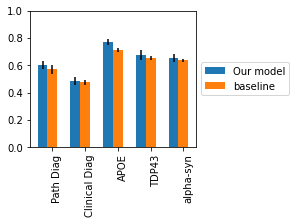

In [175]:
annoPlot_cat=np.array(['Path Diag','Clinical Diag','APOE','TDP43','alpha-syn'])
x=np.arange(annoPlot_cat.size)
width=0.3
multiplier=0

fig,ax=plt.subplots(figsize=(4,3),layout='constrained')
for tidx in range(2):
    t=modelCompareNames[tidx]
    offset=width*multiplier
    mean=np.zeros(annoPlot_cat.size)
    std=np.zeros(annoPlot_cat.size)
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
        std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std)
    multiplier+=1
ax.set_xticks(x+width,annoPlot_cat)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,1)
plt.savefig('/media/xinyi/T7 Shield/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_compare_cat_noSingle.pdf')

/tmp/ipykernel_2940739/3132061114.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/3132061114.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/3132061114.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_random_plot[annoPlot==p_curr]


Path Diag
1
0.096112405681199
2
0.014025666879148293
3
0.002708338354242362
4.057824368588747e-07
Clinical Diag
1
0.2831066099495259
2
0.007510605059035039
3
0.0023121144007495617
1.3851299494261181e-06
APOE
1
0.003123689119315956
2
0.9788729896727889
3
0.002275707937256845
5.888398321801231e-07
TDP43
1
0.07710965568714426
2
0.0990297112305073
3
0.9358800490095197
0.07514160858416151
alpha-syn
1
0.1134090218408581
2
0.004366384256269621
3
0.0023121144007495617
2.322933539275715e-05


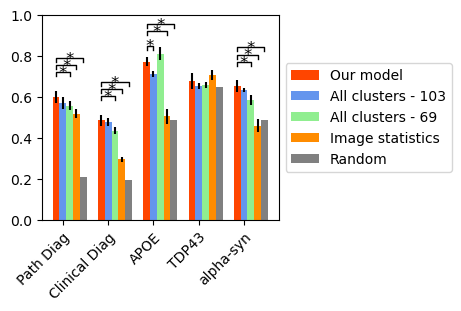

In [182]:
annoPlot_cat=np.array(['Path Diag','Clinical Diag','APOE','TDP43','alpha-syn'])
x=np.arange(annoPlot_cat.size)
width=0.15
multiplier=0

colors=['orangered','cornflowerblue','lightgreen','darkorange']
bar_positions=[]
fig,ax=plt.subplots(figsize=(4.5,3),layout='constrained')
for tidx in range(4):
    t=modelCompareNames[tidx]
    offset=width*multiplier
    mean=np.zeros(annoPlot_cat.size)
    std=np.zeros(annoPlot_cat.size)
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
        std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std,color=colors[tidx])
    multiplier+=1
    bar_positions.append(x + offset)
    
t='Random'
offset=width*multiplier
mean=np.zeros(annoPlot_cat.size)
for p_idx in range(annoPlot_cat.size):
    p_curr=annoPlot_cat[p_idx]

    mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
bars=ax.bar(x+offset,mean,width,label=t,color='gray')
multiplier+=1
bar_positions.append(x + offset)

for p_idx in range(annoPlot_cat.size):
    print(annoPlot_cat[p_idx])
    p_curr=annoPlot_cat[p_idx]
    for tidx in range(1, 4):  # Compare first bar (tidx=0) with others
        print(tidx)
        U, p_value = scipy.stats.mannwhitneyu(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_allvalues_plot[tidx,annoPlot==p_curr].flatten(), alternative='greater')
        print(p_value)
        if p_value < 0.05:
            x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
            y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.035*tidx  # Adjust for clarity
            ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y-0.02 , '*', ha='center', va='bottom', fontsize=12)
    tidx+=1
    U, p_value = scipy.stats.ttest_1samp(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_random_plot[annoPlot==p_curr], alternative='greater')
    print(p_value)
    if p_value < 0.05:
        x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
        y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.035*tidx  # Adjust for clarity
        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
        ax.text((x1 + x2) / 2, y-0.02 , '*', ha='center', va='bottom', fontsize=12)

ax.set_xticks(x+width,annoPlot_cat)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,1)
plt.savefig('/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_compare_cat_noSingle_twobaselines.pdf')

/tmp/ipykernel_2940739/1720417835.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/1720417835.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/1720417835.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
/tmp/ipykernel_2940739/1720417835.py:59: UserWarning: 

Path Diag
1
0.096112405681199
2
0.014025666879148293
3
0.002708338354242362
4.057824368588747e-07
Clinical Diag
1
0.2831066099495259
2
0.007510605059035039
3
0.0023121144007495617
1.3851299494261181e-06


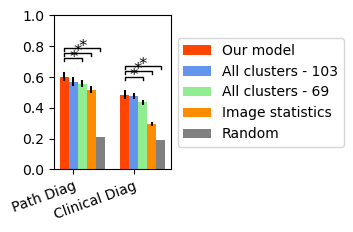

In [191]:
annoPlot_cat=np.array(['Path Diag','Clinical Diag'])
x=np.arange(annoPlot_cat.size)
width=0.15
multiplier=0

colors=['orangered','cornflowerblue','lightgreen','darkorange']
bar_positions=[]
fig,ax=plt.subplots(figsize=(1.5,2),layout='constrained')
for tidx in range(4):
    t=modelCompareNames[tidx]
    offset=width*multiplier
    mean=np.zeros(annoPlot_cat.size)
    std=np.zeros(annoPlot_cat.size)
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
        std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std,color=colors[tidx])
    multiplier+=1
    bar_positions.append(x + offset)
    
t='Random'
offset=width*multiplier
mean=np.zeros(annoPlot_cat.size)
for p_idx in range(annoPlot_cat.size):
    p_curr=annoPlot_cat[p_idx]

    mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
bars=ax.bar(x+offset,mean,width,label=t,color='gray')
multiplier+=1
bar_positions.append(x + offset)

for p_idx in range(annoPlot_cat.size):
    print(annoPlot_cat[p_idx])
    p_curr=annoPlot_cat[p_idx]
    for tidx in range(1, 4):  # Compare first bar (tidx=0) with others
        print(tidx)
        U, p_value = scipy.stats.mannwhitneyu(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_allvalues_plot[tidx,annoPlot==p_curr].flatten(), alternative='greater')
        print(p_value)
        if p_value < 0.05:
            x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
            y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.035*tidx  # Adjust for clarity
            ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y-0.02 , '*', ha='center', va='bottom', fontsize=12)
    tidx+=1
    U, p_value = scipy.stats.ttest_1samp(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_random_plot[annoPlot==p_curr], alternative='greater')
    print(p_value)
    if p_value < 0.05:
        x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
        y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.035*tidx  # Adjust for clarity
        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
        ax.text((x1 + x2) / 2, y-0.02 , '*', ha='center', va='bottom', fontsize=12)

ax.set_xticks(x+width,annoPlot_cat)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right",rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,1)
plt.savefig('/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_compare_cat_noSingle_twobaselines_diag.pdf',bbox_inches='tight')

/tmp/ipykernel_2940739/351457720.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/351457720.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/351457720.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
/tmp/ipykernel_2940739/351457720.py:59: UserWarning: cons

alpha-syn
1
0.1134090218408581
2
0.004366384256269621
3
0.0023121144007495617
2.322933539275715e-05


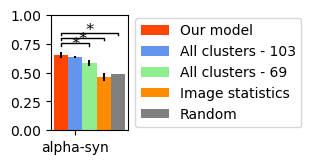

In [249]:
annoPlot_cat=np.array(['alpha-syn'])
x=np.arange(annoPlot_cat.size)
width=0.15
multiplier=0

colors=['orangered','cornflowerblue','lightgreen','darkorange']
bar_positions=[]
fig,ax=plt.subplots(figsize=(1,1.5),layout='constrained')
for tidx in range(4):
    t=modelCompareNames[tidx]
    offset=width*multiplier
    mean=np.zeros(annoPlot_cat.size)
    std=np.zeros(annoPlot_cat.size)
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
        std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std,color=colors[tidx])
    multiplier+=1
    bar_positions.append(x + offset)
    
t='Random'
offset=width*multiplier
mean=np.zeros(annoPlot_cat.size)
for p_idx in range(annoPlot_cat.size):
    p_curr=annoPlot_cat[p_idx]

    mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
bars=ax.bar(x+offset,mean,width,label=t,color='gray')
multiplier+=1
bar_positions.append(x + offset)

for p_idx in range(annoPlot_cat.size):
    print(annoPlot_cat[p_idx])
    p_curr=annoPlot_cat[p_idx]
    for tidx in range(1, 4):  # Compare first bar (tidx=0) with others
        print(tidx)
        U, p_value = scipy.stats.mannwhitneyu(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_allvalues_plot[tidx,annoPlot==p_curr].flatten(), alternative='greater')
        print(p_value)
        if p_value < 0.05:
            x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
            y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.05*(tidx-1)  # Adjust for clarity
            ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y-0.05 , '*', ha='center', va='bottom', fontsize=12)
    tidx+=1
    U, p_value = scipy.stats.ttest_1samp(resComp_allvalues_plot[0,annoPlot==p_curr].flatten(), resComp_random_plot[annoPlot==p_curr], alternative='greater')
    print(p_value)
    if p_value < 0.05:
        x1, x2 = bar_positions[0][p_idx], bar_positions[tidx][p_idx]
        y = resComp_mean_plot[0,annoPlot==p_curr]+resComp_std_plot[0,annoPlot==p_curr] + 0.035*tidx  # Adjust for clarity
        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1, c='black')
        ax.text((x1 + x2) / 2, y-0.02 , '*', ha='center', va='bottom', fontsize=12)
        
ax.set_xticks(x+width,annoPlot_cat)
# plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,1)
plt.savefig('/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_compare_cat_noSingle_twobaselines_asyn.pdf',bbox_inches='tight')

In [145]:
#plot
annoPlot_cat=np.array(['Path Diag','Clinical Diag','APOE','TDP43','alpha-syn'])
seeds=[4,8,9,10,11,12]
testepoch=3500

modelpathCompare={'Our model':'/media/xinyi/T7 Shield/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',
                 'baseline': '/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_baselineAllLatent_res5_seed',
                 'DAPI':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucDAPI/metadataClf/exp0_allMetaClf_nucSeg_baselineDAPILatent_res5_seed',
                 'GFAP':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_minmaxGFAP/metadataClf/exp0_allMetaClf_nucSeg_baselineGFAPLatent_res5_seed',
                 'MAP2':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_minmaxMAP2/metadataClf/exp0_allMetaClf_nucSeg_baselineMAP2Latent_res5_seed',
                 'LMNB':'/media/xinyi/T7 Shield/neuro/results/plots/cnnvaeexp0_segNucLMNB/metadataClf/exp0_allMetaClf_nucSeg_baselineLMNBLatent_res5_seed',}
modelCompareNames=np.array(list(modelpathCompare.keys()))

for aIdx in range(annoPlot_cat.size):
    print(annoPlot_cat[aIdx])
    resComp=np.zeros((modelCompareNames.size,len(seeds)))
    for mIdx in range(modelCompareNames.size):
        for seedIdx in range(len(seeds)):
            seed=seeds[seedIdx]
            annoName=annoPlot_cat[aIdx]
            if ' ' in annoPlot_cat[aIdx]:
                annoName=annoPlot_cat[aIdx].split(' ')
                annoName=annoName[0]+'_'+annoName[1]
            name=str(seed)+'_'+annoName
            savepath_curr=modelpathCompare[modelCompareNames[mIdx]]+name
            logsavepath=os.path.join(savepath_curr,'log')
            modelsavepath=os.path.join(savepath_curr,'model')
            plotsavepath=os.path.join(savepath_curr,'plots')
            resPath=os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv')
            if not os.path.exists(resPath):
                print(resPath)
                continue
            res=pd.read_csv(resPath,header=0,index_col=0)
            true=res.true.to_numpy()
            predicted=res.predicted.to_numpy()
            resComp[mIdx,seedIdx]=np.sum(true==predicted)/true.size
    for mIdx in range(1,modelCompareNames.size):
        print(modelCompareNames[0],' vs ',modelCompareNames[mIdx])
        print(scipy.stats.ttest_ind(resComp[0],resComp[mIdx],alternative='greater'))


Path Diag
Our model  vs  baseline
Ttest_indResult(statistic=1.6329931618554523, pvalue=0.06675982482693475)
Our model  vs  DAPI
Ttest_indResult(statistic=16.05403247669839, pvalue=9.087419173750979e-09)
Our model  vs  GFAP
Ttest_indResult(statistic=18.505830254940136, pvalue=2.2892032005745383e-09)
Our model  vs  MAP2
Ttest_indResult(statistic=4.135286170989418, pvalue=0.0010135096412711515)
Our model  vs  LMNB
Ttest_indResult(statistic=8.422151891710731, pvalue=3.7420346187204413e-06)
Clinical Diag
Our model  vs  baseline
Ttest_indResult(statistic=0.5816750507471126, pvalue=0.2868316145073917)
Our model  vs  DAPI
Ttest_indResult(statistic=18.63335275419819, pvalue=2.141069614748904e-09)
Our model  vs  GFAP
Ttest_indResult(statistic=8.693182879212229, pvalue=2.8231147508310326e-06)
Our model  vs  MAP2
Ttest_indResult(statistic=5.578592085389685, pvalue=0.00011728296488805152)
Our model  vs  LMNB
Ttest_indResult(statistic=8.18393207364568, pvalue=4.8219256418932e-06)
APOE
Our model  vs 

/tmp/ipykernel_2940739/2596937152.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/2596937152.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
/tmp/ipykernel_2940739/2596937152.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[p_idx]=resComp_random_plot[annoPlot==p_curr]


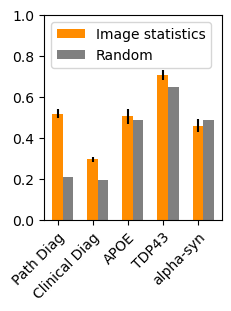

In [170]:
annoPlot_cat=np.array(['Path Diag','Clinical Diag','APOE','TDP43','alpha-syn'])
x=np.arange(annoPlot_cat.size)
width=0.3
multiplier=1

fig,ax=plt.subplots(figsize=(2.2,3),layout='constrained')
for tidx in range(3,4):
    t=modelCompareNames[tidx]
    offset=width*multiplier
    mean=np.zeros(annoPlot_cat.size)
    std=np.zeros(annoPlot_cat.size)
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        mean[p_idx]=resComp_mean_plot[tidx,annoPlot==p_curr]
        std[p_idx]=resComp_std_plot[tidx,annoPlot==p_curr]
    bars=ax.bar(x+offset,mean,width,label=t,yerr=std,color='darkorange')
    multiplier+=1
    
t='Random'
offset=width*multiplier
mean=np.zeros(annoPlot_cat.size)
for p_idx in range(annoPlot_cat.size):
    p_curr=annoPlot_cat[p_idx]

    mean[p_idx]=resComp_random_plot[annoPlot==p_curr]
bars=ax.bar(x+offset,mean,width,label=t,color='gray')
multiplier+=1
ax.set_xticks(x+width,annoPlot_cat)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.legend(loc='upper left')
ax.set_ylim(0,1)
plt.savefig('/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_cat_baselineImgStats.pdf')

In [185]:
for tidx in range(3,4):
    t=modelCompareNames[tidx]
    for p_idx in range(annoPlot_cat.size):
        p_curr=annoPlot_cat[p_idx]
        
        print(p_curr,resComp_mean_plot[tidx,annoPlot==p_curr])


Path Diag [0.51822917]
Clinical Diag [0.29532164]
APOE [0.50555556]
TDP43 [0.70707071]
alpha-syn [0.46052632]


### integrated gradients

In [8]:
import sys
sys.path.append('/home/xzhang/anaconda3/envs/neuro/lib/python3.10/site-packages/')
from captum.attr import IntegratedGradients

#### igResControl
-> use controls as baselines

In [103]:
for anno in annoPlot_cat:
    print(anno)
    pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
    print(pathDiag_unique_keep)

Path Diag
['AD' 'Control' 'FTLD-TDPC' 'IPD' 'PSP']
Clinical Diag
['AD' 'CBD' 'Control' 'FTD-AD' 'FTD-MND' 'FTD-SD' 'FTLD' 'FTLD-PNFA'
 'FTLD-PPA' 'IPD' 'NFA' 'Non specific demetia' 'PD' 'PSP' 'atypical FTD'
 'bvFTD']
APOE
['24' '33' '34' 'nan']
TDP43
['0.0' '1.0' 'nan']
alpha-syn
['0.0' '1.0' 'nan']


In [109]:
seeds=[4,8,9,10,11,12]
annoPlot_cat=np.array(['Path Diag','Clinical Diag','APOE','TDP43','alpha-syn'])
annoPlot_baseline={'Path Diag':'Control',
                   'Clinical Diag':'Control',
                   'APOE':'33',
                   'TDP43':'0.0',
                   'alpha-syn':'0.0'}

for anno in annoPlot_cat:
    print(anno)
    regrs=False
        
    
    #construct labels
    
    meta['keep']=True
    if anno not in annoUsed_numeric:
        pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
        pathDiag_unique_keep[pathDiag_counts_keep<=1]='remove'
        pathDiag_unique_keep=pathDiag_unique_keep[pathDiag_inverse_keep]

        meta['keep']=pathDiag_unique_keep!='remove'
    
    meta_allcells=meta.loc[allPatientIDs][anno].to_numpy().astype(str)
    cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
    cellIdx=np.logical_and(cellIdx,meta.loc[allPatientIDs]['keep'].to_numpy())
    allCat=meta_allcells[cellIdx]
    
    allImgNames_a=allImgNames[cellIdx]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)
    
    #get cluster composition
    clusterUnique=np.unique(finalPartition_keep_input)
    inputCluster=np.zeros((sUnique.size,clusterUnique.size))
    for i in range(sUnique.size):
        clusterRes_i=finalPartition_keep_input[allImgNames==sUnique[i]]
        for j in range(clusterUnique.size):
            inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
    inputAll=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)


    pathDiag_unique,labels,pathDiag_counts=np.unique(allCat[sidx_start],return_counts=True,return_inverse=True)
    weights=np.sum(pathDiag_counts)/pathDiag_counts
    if labels.size<2:
        continue
    annoName=anno
    if ' ' in anno:
        annoName=anno.split(' ')
        annoName=annoName[0]+'_'+annoName[1]
        
    true_label=np.copy(pathDiag_unique[labels]).astype(str)
    inputBaseline=inputAll[true_label==annoPlot_baseline[anno]]
    for seed in seeds:
        print('seed: ',seed)
        name='exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed'+str(seed)+'_'+annoName
        savepath_curr=os.path.join(saveDir,'metadataClf',name)
        if not os.path.exists(os.path.join(saveDir,'metadataClf')):
            os.mkdir(os.path.join(resDir,'metadataClf'))
        if not os.path.exists(savepath_curr):
            os.mkdir(savepath_curr)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')

#         if os.path.exists(os.path.join(plotsavepath,'predictions'+str(5900)+'.csv')):
#             continue

        pIDList=allPatientIDs[sidx_start]
    
        use_cuda=True
        testepoch=3500
        batchsize=32
        model_str='fc3'
        fc_dim=256
        
        fc_dim1=fc_dim
        fc_dim2=fc_dim
        fc_dim3=fc_dim

        if regrs:
            nclasses=1
        else:
            nclasses=np.unique(labels).size

        igRes=np.zeros_like(inputAll)
        igResPred=np.zeros_like(inputAll)

        for patientIDX in range(np.unique(pIDList).size):
            patientID=np.unique(pIDList)[patientIDX]
    #         print(patientID,patientIDX)
            sampleIdx=np.arange(inputAll.shape[0])[pIDList==patientID]
            trainIdx=np.arange(inputAll.shape[0])[pIDList!=patientID]
            
            inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()
            for ibIdx in range(inputBaseline.shape[0]):
                inputBaseline_t=torch.tensor(inputBaseline[[ibIdx]],requires_grad=True).cuda().float()
    #             labels=torch.tensor(labels).cuda().long()

                seed=3
                torch.manual_seed(seed)
                if use_cuda:
                    torch.cuda.manual_seed(seed)

                nfeatures=inputAll.shape[1]

                model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=regrs)
                if use_cuda:
                    model.cuda()

                model.load_state_dict(torch.load(os.path.join(modelsavepath,patientID+'_'+str(testepoch)+'.pt')))
                with torch.no_grad():
                    model.cuda()
                    model.eval()
                    ig = IntegratedGradients(model)
                    attributions= ig.attribute(inputAll_t, baselines=inputBaseline_t,target=torch.tensor(labels[sampleIdx]).cuda())
                    igRes[sampleIdx]+=attributions.cpu().numpy()

                    pred = model(inputAll_t)
                    attributions= ig.attribute(inputAll_t, baselines=inputBaseline_t,target=torch.argmax(pred,axis=1))
                    igResPred[sampleIdx]+=attributions.cpu().numpy()
        igRes=igRes/inputBaseline.shape[0]
        igResPred=igResPred/inputBaseline.shape[0]
        with open(os.path.join(plotsavepath,'igResControl_'+str(testepoch)), 'wb') as output:
            pickle.dump(igRes,output,pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(plotsavepath,'igResControlPred_'+str(testepoch)), 'wb') as output:
            pickle.dump(igResPred,output,pickle.HIGHEST_PROTOCOL)


Path Diag
seed:  4


<ipython-input-109-a5e01e64a9b1>:94: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()


seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
Clinical Diag
seed:  4


<ipython-input-109-a5e01e64a9b1>:94: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()


seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
APOE
seed:  4


<ipython-input-109-a5e01e64a9b1>:94: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()


seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
TDP43
seed:  4


<ipython-input-109-a5e01e64a9b1>:94: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()


seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
alpha-syn
seed:  4


<ipython-input-109-a5e01e64a9b1>:94: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inputAll_t=torch.tensor(inputAll[[sampleIdx]],requires_grad=True).cuda().float()


seed:  8
seed:  9
seed:  10
seed:  11
seed:  12


### plot heatmap

In [80]:
from sklearn.decomposition import PCA
import umap

In [94]:
def show_embedding_wBG(plotting_df, x_lab='umap1', y_lab='umap2', hue_lab='Cluster', savepath=None):
    # Set color palette with 'not validated' category to gray
    custom_palette = sns.color_palette("Paired",np.unique(plotting_df[hue_lab]).size)
    custom_palette[-1] = (0.5, 0.5, 0.5)  # Gray color
    
    # Ensure 'not validated' category is at the front
    
    if 'not validated' in plotting_df[hue_lab]:
        hue_order=set(plotting_df[hue_lab])
        hue_order.remove('not validated')
        hue_order = list(np.sort(plotting_df[hue_lab].astype(int)).astype(str))
        hue_order.append('not validated')
    else:
        hue_order = sorted(set(plotting_df[hue_lab]))
    
    plt.figure(figsize=(15, 13))
    ax = sns.scatterplot(
        data=plotting_df,
        x=x_lab,
        y=y_lab,
        style=hue_lab,
        hue=hue_lab,
        hue_order=hue_order,
        palette=custom_palette  # Use custom color palette
    )
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_xlabel("")  
    ax.set_ylabel("") 
    
    if savepath is None:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(savepath)
        plt.show()

In [69]:
plotsavepath_analysis='/media/xinyi/T7 Shield/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/plots'
if not os.path.exists(plotsavepath_analysis):
    os.mkdir(plotsavepath_analysis)
plotsavepath_analysis=os.path.join(plotsavepath_analysis,'exp0_allMetaClf_nucSeg_modSilFilter_2_res5')
if not os.path.exists(plotsavepath_analysis):
    os.mkdir(plotsavepath_analysis)

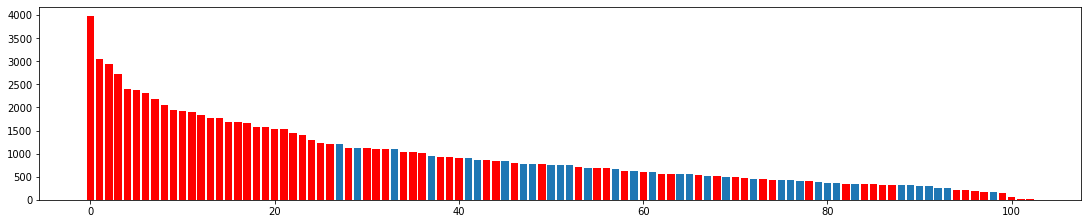

In [70]:
_,allcounts=np.unique(finalPartition,return_counts=True)
fig,ax=plt.subplots(figsize=(15,3),layout='constrained')
plt.bar(np.arange(allcounts.size),allcounts)
plt.bar(np.arange(allcounts.size)[finalPartition_keep],allcounts[finalPartition_keep],color='red')
plt.savefig(os.path.join(plotsavepath_analysis,'clusterSizes.jpg'))

In [97]:
np.min(allcounts)

21

In [98]:
np.sum(finalPartition_keep_input==-1)

20534

In [66]:
with open(os.path.join(savedir_processed,'allLatent_epoch458_nucSeg'), 'rb') as output:
    latent_all=pickle.load(output)

In [81]:
#UMAP - grey for not validated
n_neighbors=10
min_dist=0.25
np.random.seed(3)
plotPCT=0.1
plottingIdx=np.arange(latent_all.shape[0])
np.random.shuffle(plottingIdx)
plottingIdx=plottingIdx[:int(plotPCT*plottingIdx.size)]

n_pcs_all=50
pca=PCA(n_components=n_pcs_all)
latent_all_pca=pca.fit_transform(latent_all[plottingIdx])
reducer_all = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=3).fit(latent_all_pca)



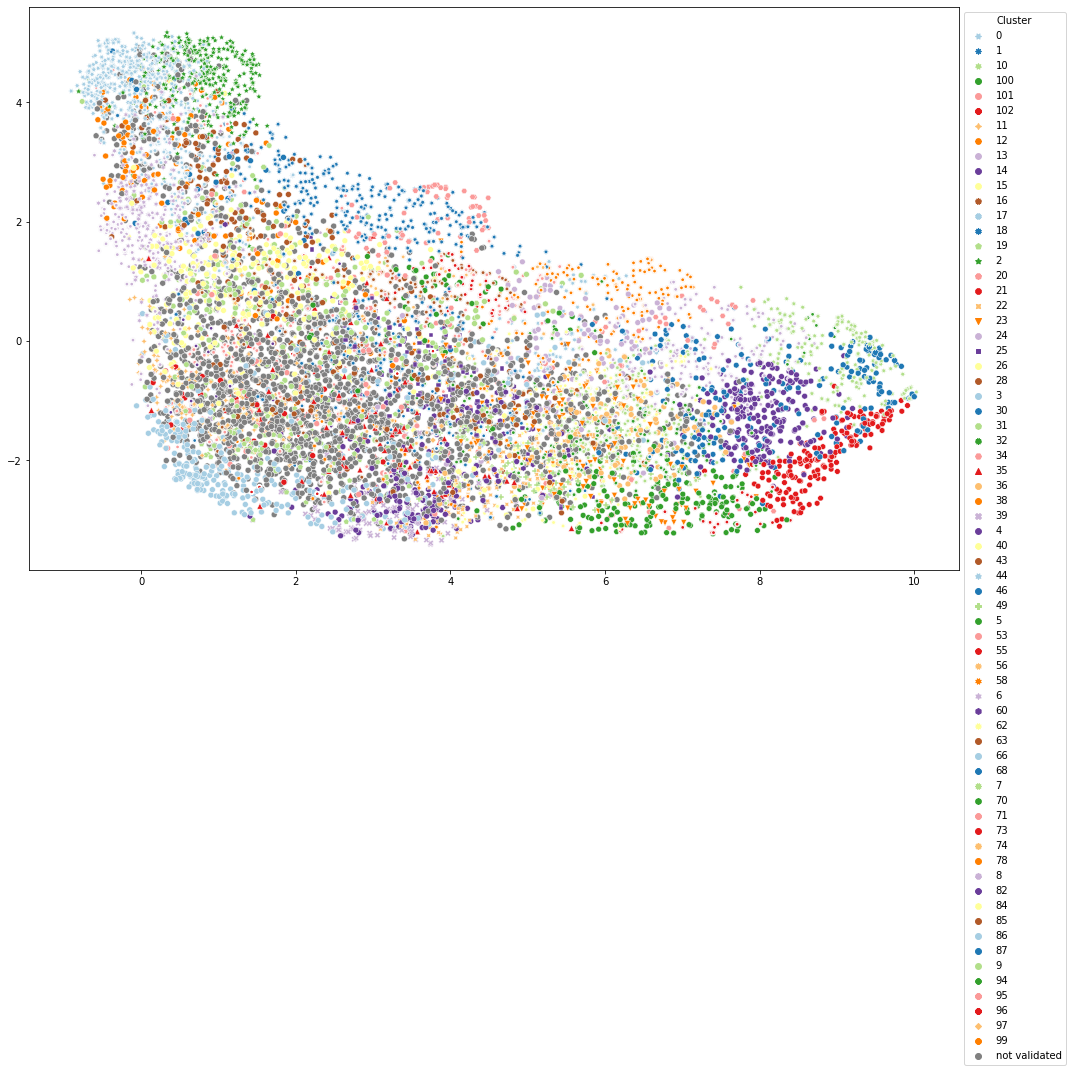

In [96]:
finalPartition_keep_plot=np.copy(finalPartition_keep_input).astype(str)
finalPartition_keep_plot[finalPartition_keep_plot=='-1']='not validated'
plotting_df = pd.DataFrame(
    {"Cluster":finalPartition_keep_plot[plottingIdx],
     "umap1":reducer_all.embedding_[:,0],
     "umap2":reducer_all.embedding_[:,1],
    }
)

show_embedding_wBG(plotting_df, x_lab='umap1', y_lab='umap2', hue_lab='Cluster', savepath=os.path.join(plotsavepath_analysis,'clusterUMAP.pdf'))


In [83]:
finalPartition_keep_plot.shape

(97530,)

In [84]:
reducer_all.embedding_.shape

(9753, 2)